## Data Exploration for Albuquerque Crime Data

In [1]:
import os
import time

import pyproj
import shapely
import abq_utils
import numpy as np
import pandas as pd

import gmaps
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.style.use("ggplot")

### Load the Data

In [3]:
data_path = "/Users/administrator/Documents/Projects/abq_crime/data/processed_dataframe.pkl"

In [4]:
dataframe = pd.read_pickle(data_path)
dataframe.head()

,Object_ID,Location,Description,Day of Week,Date,Latitude,Longitude
0,45420062,I25 NORTHBOUND SE / COAL AV SE,TRAFFIC STOP,Tuesday,2020/09/22,35.078682,-106.637350
1,45420063,COORS BL NW / SEQUOIA RD NW,TRAFFIC STOP,Tuesday,2020/09/22,35.121313,-106.701621
2,45420064,COORS BL NW / EAGLE RANCH RD NW,DIRECT TRAFFIC,Tuesday,2020/09/22,35.174464,-106.673685
3,45420065,BRYN MAWR DR NE / MENAUL BL NE,TRAFFIC STOP,Tuesday,2020/09/22,35.109201,-106.609120
4,45420066,I25 NORTHBOUND SE / COAL AV SE,TRAFFIC STOP,Tuesday,2020/09/22,35.078682,-106.637350


#### Crimes by the Day of the Week

* We analyze the number of crimes by the day of the week.

In [ ]:
def change_bar_width(ax, new_width):
    """Changes the width of the bars in a bar plot.
    
    Parameters
    ----------
    ax : matplotlib.Axes instance
        The axes used to set the new patch widths.
    new_width : double > 0
        The new width of the bars.

    Returns
    -------
    None

    """
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff * 0.5)

In [ ]:
# Obtain the distribution of crimes, based on the day of the week.
crimes_dow = dataframe["Day of Week"].value_counts()
total_crimes = crimes_dow.sum()

crimes_dow = pd.DataFrame(crimes_dow).reset_index()
crimes_dow.columns = ["Day of Week", "Count"]
crimes_dow["Count"] = crimes_dow["Count"].apply(lambda x: x / total_crimes)

# Plot the distribution of crimes based on the day of the week.
plt.rcParams["figure.figsize"] = (20, 14)
barplot = plt.bar(crimes_dow["Day of Week"], crimes_dow["Count"], color="#945dd4", alpha=0.85)
change_bar_width(barplot, 0.40)
barplot[0].set_color("#4653e4")

# Plot the percentages on top of the bars.
for bar in barplot:
    height = bar.get_height()
    height_percent = height * 100
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, "{:.2f}%".format(height_percent), ha="center", va="bottom", fontsize=15)

# Fix the font and visualization.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

It looks like Friday and Saturday have the highest percentage of crimes, whereas Sunday and Monday have the lowest percentage of crimes.

#### Crimes by their Description

* Now we analyze their crimes by the description.

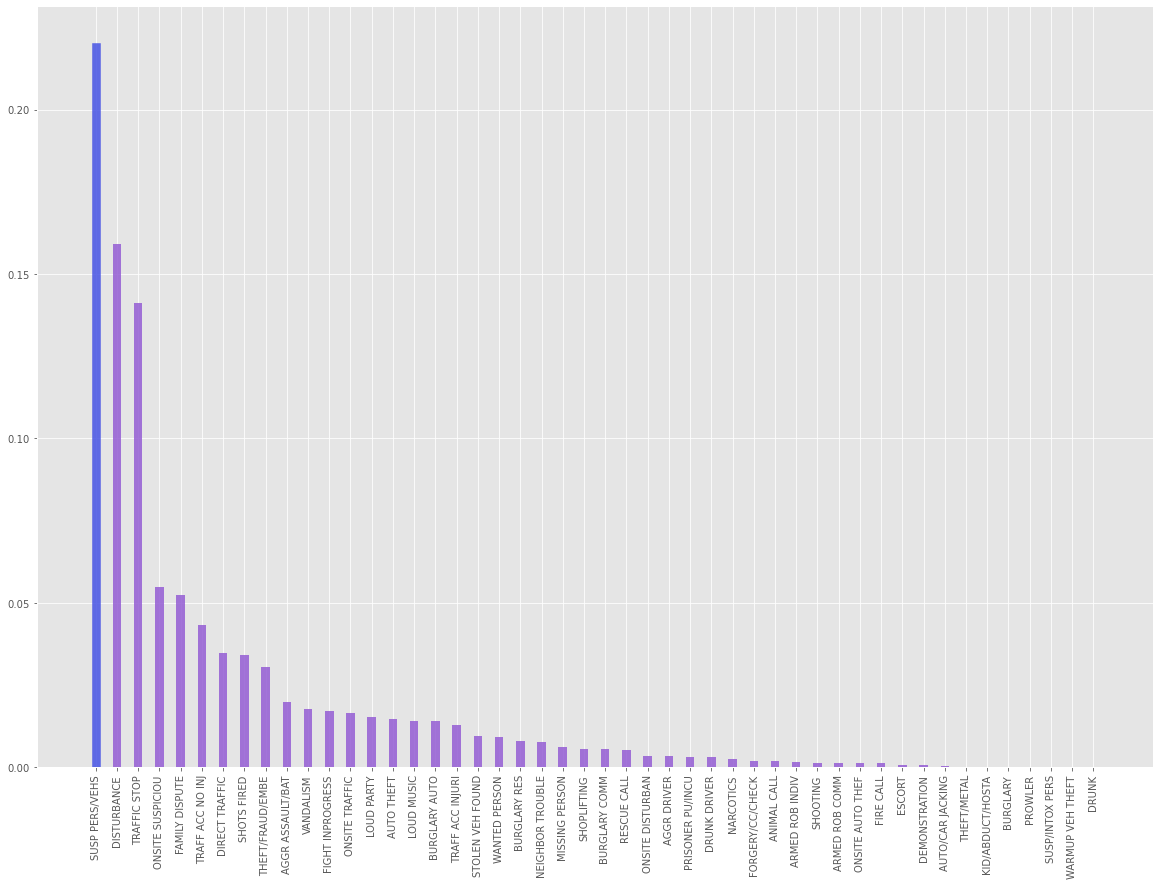

In [7]:
# Obtain the distribution of crimes, based on the description.
crimes_description = dataframe["Description"].value_counts()
total_crimes = crimes_description.sum()

crimes_description = pd.DataFrame(crimes_description).reset_index()
crimes_description.columns = ["Description", "Count"]
crimes_description["Count"] = crimes_description["Count"].apply(lambda x: x / total_crimes)

# Plot the distribution of crimes based on the description of the crime.
plt.rcParams["figure.figsize"] = (20, 14)
barplot = plt.bar(crimes_description["Description"], crimes_description["Count"], color="#945dd4", alpha=0.85)
change_bar_width(barplot, 0.40)
barplot[0].set_color("#4653e4")

# Plot the percentages on top of the bars.
"""
for bar in barplot:
    height = bar.get_height()
    height_percent = height * 100
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, "{:.2f}%".format(height_percent), ha="center", va="bottom", fontsize=15)
"""
_ = plt.xticks(rotation=90)

Not super informative, we should maybe take the top 10 crimes and print their percentages.

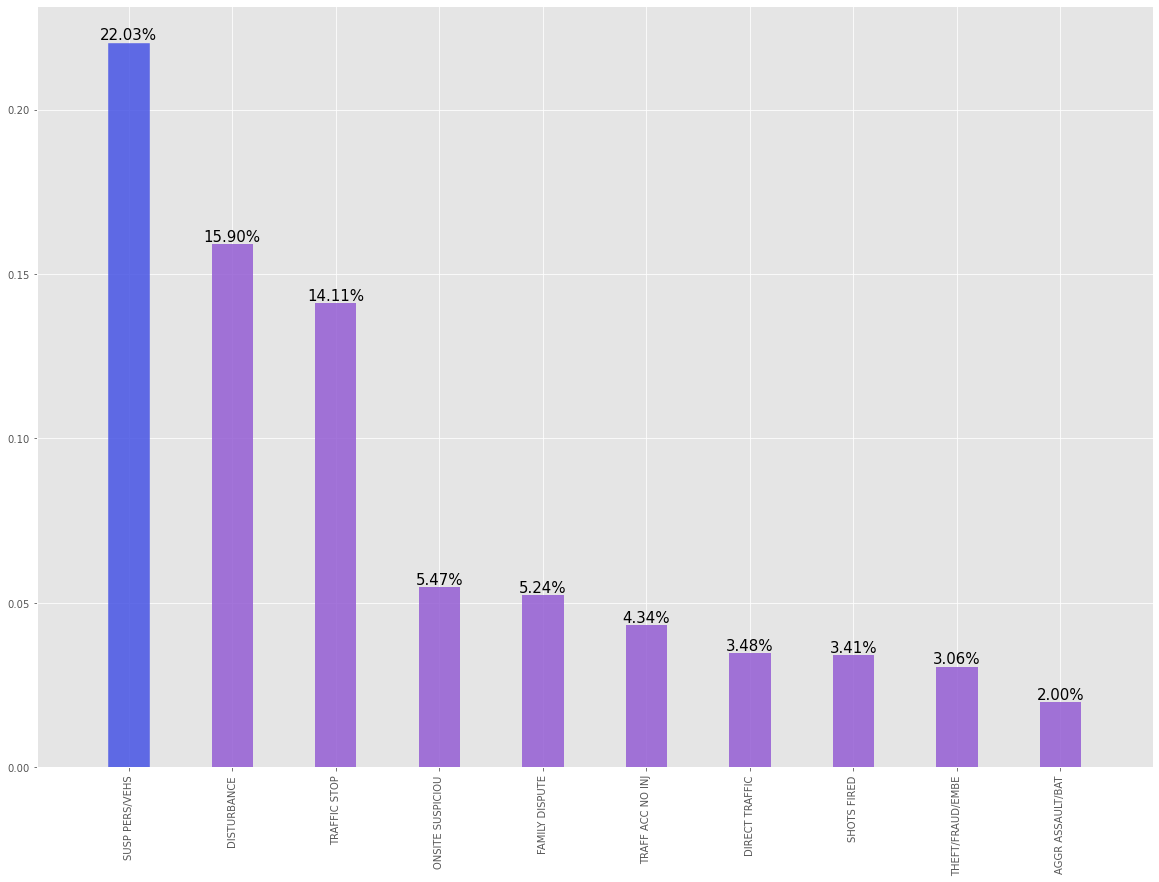

In [8]:
top_ten_crimes = crimes_description[0:10]

barplot = plt.bar(top_ten_crimes["Description"], top_ten_crimes["Count"], color="#945dd4", alpha=0.85)
change_bar_width(barplot, 0.40)
barplot[0].set_color("#4653e4")

for bar in barplot:
    height = bar.get_height()
    height_percent = height * 100
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, "{:.2f}%".format(height_percent), ha="center", va="bottom", fontsize=15)

_ = plt.xticks(rotation=90)

Summary of Results:
* The top two crimes are suspicious persons/vehicles and disturbances, at 22.03% and 15.90% of all reported incidents.
* The tenth most frequent crime is aggravated assault at 2.00% of all incid ents.
* Shots fired is among the top ten incidents, clocking in at 3.41% of all incidents. Since there are 30,000 incidents in total, this means that there were 1,023 cases of shots fired. That is alot! 

#### Hotspot Analysis

* Analysis of where crimes are most prevalent by plotting them on Google Maps using the Google Maps API.

In [9]:
import gmaps 

# API Authentication
key_path = "/Users/administrator/Documents/Projects/abq_crime/api_key.txt"
with open(key_path) as f:
    api_key = f.readline()
    f.close()

# Initialize a session.
gmaps.configure(api_key)

In [10]:
# Extract the locations from the dataset
locatable_incidents = dataframe.dropna()
incident_locations = locatable_incidents[["Latitude", "Longitude"]]

# Set up the map and plot it.
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(incident_locations)
fig.add_layer(heatmap_layer)

# Calibrate the map style.
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 5

fig

Figure(layout=FigureLayout(height='420px'))

From a basic analysis, it looks like Taylor Ranch and Los Ranchos De Albuquerque are two of the safer areas.

On the other hand, the area near the Air Force Base and Sandia contains a clusuter of crime.

Idea:

* The heatmap is not that informative. Instead, we should split the city into polygons and then color the polygons by the frequency of crimes that appear in that area.

### Plotting the Zip Code Areas

In [11]:
import time

import shapely
import pyproj
import pandas as pd
from tqdm import tqdm

import gmaps
import geopandas as gpd

In [12]:
# Authenticate the API key.
key_path = "/Users/administrator/Documents/Projects/abq_crime/api_key.txt"
with open(key_path) as f:
    api_key = f.readline()
    f.close()

# Initialize a session.
gmaps.configure(api_key=api_key)

In [13]:
# Load the Zip Code shape file.
shapefile_path = "/Users/administrator/Documents/Projects/abq_crime/shapefiles/zipcodes/zipcodes.shp"
zipcode_shapefile = gpd.read_file(shapefile_path)

In [14]:
# Utility functions.
def convert_coordinates(coordinates, transformer=None):
    """Converts coordinates from the EPSG:2258 standard to the EPSG:4326 standard.

    Parameters
    ----------
    coordinates : tuple (int, int)
        Tuple containing the coordinates in the EPSG:2258 standard.
    transformer : pyproj.transformer.Transformer instance
        Instance of a pyproj transformer used for converting the coordinates, by default None. If no transformer is specified, then the default transformer that converts EPSG:2258 to EPSG:4326 is used.
    
    Returns
    -------
    trans_coordinates : tuple (int, int)
        Tuple containing the coordinates in the EPSG:4326 standard.

    """
    if transformer is None:
        transformer = pyproj.Transformer.from_crs("epsg:2258", "epsg:4326")
    
    trans_coordinates = transformer.transform(coordinates[0], coordinates[1])

    return trans_coordinates

def batch_convert_coordinates(coord_list, transformer=None):
    """Converts a batch of coordinates from the EPSG:2258 standard to the EPSG:4326 standard.

    Parameters
    ----------
    coord_list : list of tuples (int, int)
        List containing tuples containing the coordinates in the EPSG:2258 standard.
    transformer : pyproj.transformer.Transformer instance
        Instance of a pyproj transformer used for converting the coordinates, by default None. If no transformer is specified, then the default transformer that converts EPSG:2258 to EPSG:4326 is used.

    Returns
    -------
    trans_coord_list : list of tuples (int, int)
        List containing tuples of coordinates in the EPSG:4326 standard.

    """
    if transformer is None:
        transformer = pyproj.Transformer.from_crs("epsg:2258", "epsg:4326")
    
    trans_coord_list = list()
    for coord in coord_list:
        trans_coord_list.append(convert_coordinates(coord, transformer=transformer))

    return trans_coord_list

In [15]:
# Extract the coordinates and convert them to (latitude, longitude).
zipcode_polygons = list()
for idx in tqdm(range(len(zipcode_shapefile["geometry"]))):
    if type(zipcode_shapefile["geometry"][idx]) == shapely.geometry.multipolygon.MultiPolygon:
        for poly in zipcode_shapefile["geometry"][idx]:
            zipcode_polygons.append(batch_convert_coordinates(poly.exterior.coords[:]))
    else:
        zipcode_polygons.append(batch_convert_coordinates(zipcode_shapefile["geometry"][idx].exterior.coords[:]))

100%|██████████| 27/27 [00:06<00:00,  4.48it/s]


In [16]:
# Create a list of gmaps Polygons for plotting.
drawing_list = list()
for polygon_coords in tqdm(zipcode_polygons):
    drawing_list.append(gmaps.Polygon(polygon_coords, stroke_color="red", fill_color=(217, 136, 128),))

100%|██████████| 28/28 [00:00<00:00, 78.04it/s]


In [17]:
# Plot the Polygons using gmaps.
fig = gmaps.figure(center=(35.08541434188005, -106.65083179442777), zoom_level=12)
drawing = gmaps.drawing_layer(features=drawing_list, show_controls=False,)
fig.add_layer(drawing)
fig

Figure(layout=FigureLayout(height='420px'))

In [18]:
# Overlay the zip codes with the heatmap.
fig = gmaps.figure(center=(35.08541434188005, -106.65083179442777), zoom_level=12)

drawing = gmaps.drawing_layer(features=drawing_list, show_controls=False,)
fig.add_layer(drawing)

heatmap_layer = gmaps.heatmap_layer(incident_locations)
fig.add_layer(heatmap_layer)

# Calibrate the map style.
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 5

fig

Figure(layout=FigureLayout(height='420px'))

The code above was able to plot the Zip Code areas. The next thing to try is see if we can weight the color to reflect the number of crime offenses that occur in the specific zip code.

We can create a list there the first element of the list contains the coordinates and then the second element contains the crime count/weight.

### ZipCodes with Weights

* The code above plots the Zip Code areas. The next thing to try is see if we can weight the color to reflect the number of crime offenses that occur in the specific zip code.